# DATA INFORMATION

Nguồn data: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m

Mô tả dataset: Bộ dữ liệu này chứa nhiều thông tin khách hàng được thu thập từ danh mục thẻ tín dụng tiêu dùng, với mục đích giúp các nhà phân tích dự đoán tỷ lệ mất khách hàng. Bộ dữ liệu gồm 23 cột

- **CLIENTNUM**: Mã định danh duy nhất cho mỗi khách hàng. (Integer)
- **Attrition_Flag**: Cờ cho biết khách hàng đã ngừng sử dụng dịch vụ hay chưa. (Boolean)
- **Customer_Age**: Độ tuổi của khách hàng. (Integer)
- **Gender**: Giới tính của khách hàng. (String)
- **Dependent_count**: Số người phụ thuộc mà khách hàng có. (Integer)
- **Education_Level**: Trình độ học vấn của khách hàng. (String)
- **Marital_Status**: Tình trạng hôn nhân của khách hàng. (String)
- **Income_Category**: Loại thu nhập của khách hàng. (String)
- **Card_Category**: Loại thẻ mà khách hàng nắm giữ. (String)
- **Months_on_book**: Thời gian khách hàng có trong sổ sách. (Integer)
- **Total_Relationship_Count**: Tổng số mối quan hệ mà khách hàng có với nhà cung cấp thẻ tín dụng. (Integer)
- **Months_Inactive_12_mon**: Số tháng khách hàng không hoạt động trong mười hai tháng qua. (Integer)
- **Contacts_Count_12_mon**: Số lượng liên hệ mà khách hàng đã có trong mười hai tháng qua. (Integer)
- **Credit_Limit**: Hạn mức tín dụng của khách hàng. (Integer)
- **Total_Revolving_Bal**: Tổng số dư luân chuyển của khách hàng. (Integer)
- **Avg_Open_To_Buy**: Tỷ lệ mở để mua trung bình của khách hàng. (Integer)
- **Total_Amt_Chng_Q4_Q1**: Tổng số tiền thay đổi từ quý 4 sang quý 1. (Integer)
- **Total_Trans_Amt**: Tổng số tiền giao dịch. (Integer)
- **Total_Trans_Ct**: Tổng số giao dịch. (Integer)
- **Total_Ct_Chng_Q4_Q1**: Tổng số lượng thay đổi từ quý 4 sang quý 1. (Integer)
- **Avg_Utilization_Ratio**: Tỷ lệ sử dụng trung bình của khách hàng. (Integer)
- **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1**: Bộ phân loại Naive Bayes để dự đoán liệu ai đó có rời bỏ hay không dựa trên các đặc điểm (Integer)

# **TIỀN XỬ LÝ DỮ LIỆU**

## 1. IMPORT LIBRARIES

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *

#Tạo kết nối Spark session
spark = SparkSession.builder \
    .appName("DataProcessing") \
    .getOrCreate()

#Import thư viện cần thiết
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from math import comb
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.colors import ListedColormap
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# PySpark MLlib for machine learning
from pyspark.ml.feature import StringIndexer, PCA
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

## 2. IMPORT DATASET

In [ ]:
# Đọc dữ liệu từ thư mục CSV
# data = spark.read.format("csv") \
#     .option("header", "true") \
#     .option("inferSchema", "true") \
#     .load("/home/kanh/Desktop/Project/dataset/")

# Define the file path
file_path = "/content/BankChurners.csv"

# Read the dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
#Hiển thị số lượng datapoint
num_data_points = data.count()
print(f"Number of datapoints: {num_data_points}")

#Hien thi 5 dong dau tien cua data
data.show(5)

Number of datapoints: 10127
+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|N

## 3. DATA CLEANING
- Data cleaning
- Feature Engineering

In [ ]:
#In so do cua DataFrame
data.printSchema()

# Mo ta dataframe de tinh xac suat
data.select(*(f.name for f in data.schema.fields if f.dataType.typeName() in ['integer', 'double'])).describe().show()

# Dem cac gia tri khac NULL
from pyspark.sql.functions import col, count, isnan, when

def count_not_null(c):
    return count(when(col(c).isNotNull() & ~isnan(col(c)), c))

non_null_counts = data.agg(*(count_not_null(c).alias(c) for c in data.columns))
non_null_counts.show()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

 **Nhận xét**:
- Dataset không có giá trị NULL/trống
- **Độ tuổi trung bình** của khách hàng được dự đoán là 46 tuổi. Các khách hàng có độ tuổi nằm trong khoảng từ 26 đến 73 tuổi.
- Trung bình, **mỗi khách hàng có 2 người phụ thuộc**.
- Một khách hàng trung bình có thời gian sử dụng dịch vụ (thời gian "on books") là **36 tháng**.
- Mỗi khách hàng thường có tổng cộng **4 mối quan hệ** với nhà cung cấp thẻ tín dụng.
- **Hạn mức tín dụng** trung bình mà nhà cung cấp thẻ tín dụng hoặc tổ chức tài chính cung cấp là **8.492,77 USD**. Tuy nhiên, độ lệch chuẩn lớn cho thấy rằng các khách hàng có hạn mức tín dụng rất khác nhau, điều này được thể hiện qua khoảng giá trị từ **1.438 USD đến 34.516 USD**.
- Trung bình, tổng số tiền giao dịch của một khách hàng là **4.394,30 USD**.
- Tổng số lượng giao dịch trung bình của mỗi khách hàng là **65 giao dịch**.

### **Kiểm tra các biến phân loại có trong DataFrame**

Theo mô tả, ta có các biến phân loại như: Education_level, Marial_Status, Income_Category, Card_Category.

In [ ]:
#Xem bien phan loai Education_level
Education_counts = data.groupBy("Education_Level").count()
Education_counts.show()

#Xem bien phan loai Marial_Status
Marial_counts = data.groupBy("Marital_Status").count()
Marial_counts.show()

#Xem bien phan loai Income_Category
Income_counts = data.groupBy("Income_Category").count()
Income_counts.show()

#Xem bien phan loai Card_Category
Card_counts = data.groupBy("Card_Category").count()
Card_counts.show()

+---------------+-----+
|Education_Level|count|
+---------------+-----+
|    High School| 2013|
|        Unknown| 1519|
|     Uneducated| 1487|
|  Post-Graduate|  516|
|      Doctorate|  451|
|       Graduate| 3128|
|        College| 1013|
+---------------+-----+

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|       Unknown|  749|
|       Married| 4687|
|      Divorced|  748|
|        Single| 3943|
+--------------+-----+

+---------------+-----+
|Income_Category|count|
+---------------+-----+
|        $120K +|  727|
|    $60K - $80K| 1402|
|   $80K - $120K| 1535|
|        Unknown| 1112|
|    $40K - $60K| 1790|
| Less than $40K| 3561|
+---------------+-----+

+-------------+-----+
|Card_Category|count|
+-------------+-----+
|     Platinum|   20|
|       Silver|  555|
|         Blue| 9436|
|         Gold|  116|
+-------------+-----+



In [ ]:
# Chuẩn hóa giá trị các cột chuỗi: xóa khoảng trắng, chuyển về chữ in hoa
for column in data.columns:
    if isinstance(data.schema[column].dataType, StringType):  # Chỉ áp dụng cho cột kiểu string
        data = data.withColumn(column, trim(upper(col(column))))

# Xóa các dòng có giá trị 'UNKNOWN' hoặc null chỉ trong cột chuỗi
columns_to_check = [col(column) for column in data.columns if isinstance(data.schema[column].dataType, StringType)]
filter_condition = ~((columns_to_check[0] == "UNKNOWN") | columns_to_check[0].isNull())  # Điều kiện cho cột đầu tiên

for column in columns_to_check[1:]:  # Thêm điều kiện cho các cột còn lại
    filter_condition &= ~((column == "UNKNOWN") | column.isNull())

data = data.filter(filter_condition)

# Hiển thị DataFrame sau khi xử lý
print("DataFrame sau khi loại bỏ 'Unknown' và null:")
data.show()

DataFrame sau khi loại bỏ 'Unknown' và null:
+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Ut

In [ ]:
#Hien thi so luong datapoint
num_data_points = data.count()
print(f"Number of datapoints: {num_data_points}")

Number of datapoints: 7081


In [ ]:
#Xoa cac thuoc tinh khong can thiet
data = data.drop(
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
)

In [ ]:
data.describe().show()

+-------+-----------------+------------------+------+-----------------+---------------+--------------+---------------+-------------+-----------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+------------------+-------------------+---------------------+
|summary|   Attrition_Flag|      Customer_Age|Gender|  Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|   Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|    Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+-----------------+------------------+------+-----------------+---------------+--------------+---------------+-------------+-----------------+------------------------+----------------------+---------------------+-----------------+--------

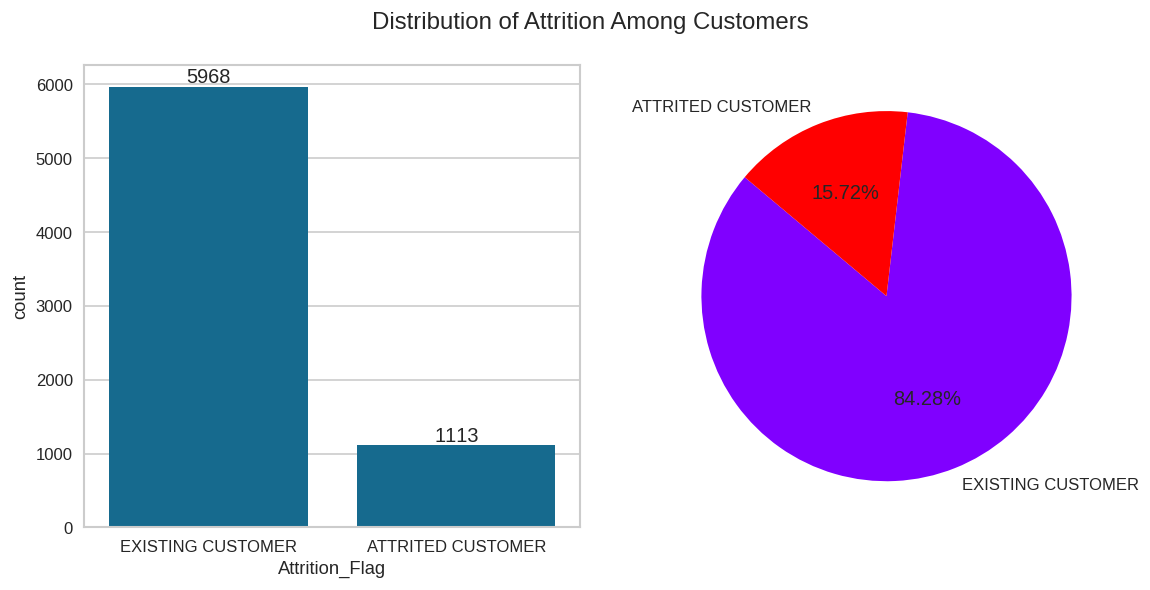

In [ ]:
# Chuyển đổi PySpark DataFrame sang Pandas DataFrame với cột Attrition_Flag
data_pandas = data.toPandas()

# Vẽ biểu đồ phân phối
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Distribution of Attrition Among Customers')

# Biểu đồ cột
sns.countplot(data=data_pandas, x='Attrition_Flag', ax=axes[0])
axes[0].bar_label(axes[0].containers[0])

# Biểu đồ tròn
data_pandas['Attrition_Flag'].value_counts().plot.pie(autopct="%1.2f%%", startangle=140, ax=axes[1], cmap='rainbow', ylabel='')

plt.tight_layout()
plt.show()

**Nhận xét**:
Những biểu đồ trên đã thể hiện chính xác tỷ lệ phần trăm khách hàng rời bỏ và khách hàng còn lại. Khoảng 16% khách hàng đã ngừng sử dụng thẻ tín dụng.

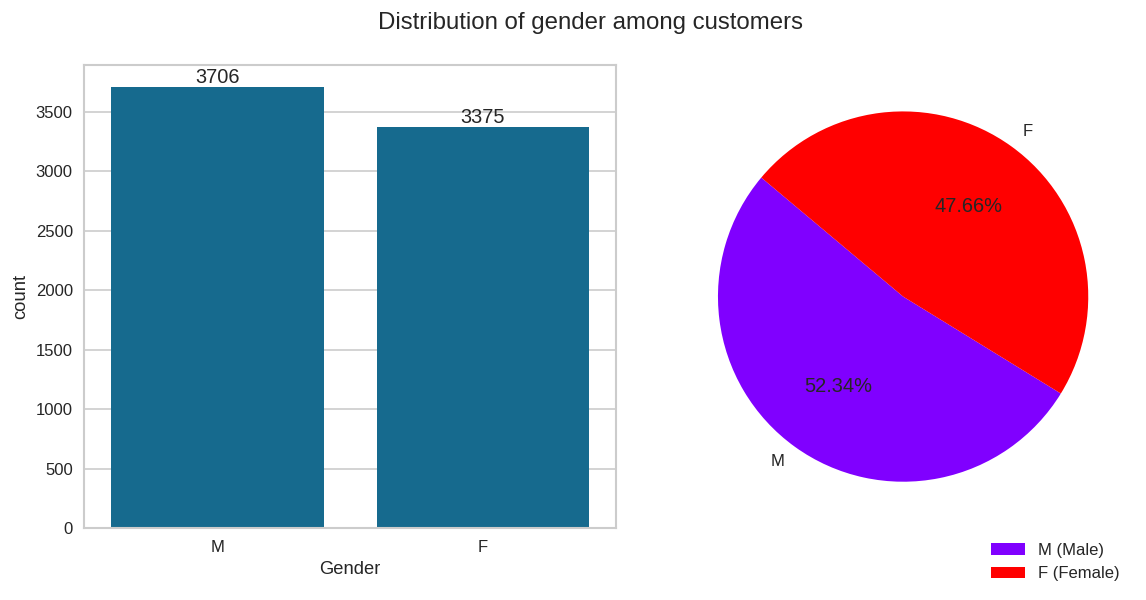

In [ ]:
# Vẽ biểu đồ phân phối
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Distribution of gender among customers')

# Biểu đồ cột
sns.countplot(data=data_pandas, x='Gender', ax=axes[0])
axes[0].bar_label(axes[0].containers[0])

# Biểu đồ tròn
data_pandas['Gender'].value_counts().plot.pie(autopct="%1.2f%%", startangle=140, ax=axes[1], cmap='rainbow', ylabel='')
axes[1].legend(['M (Male)', 'F (Female)'],bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

 **Nhận xét**:
Chúng ta có được một tỷ lệ khá cân bằng dựa trên giới tính của các khách hàng.

<ipython-input-13-f17a3e28fff6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Education_Level',palette='tab10')


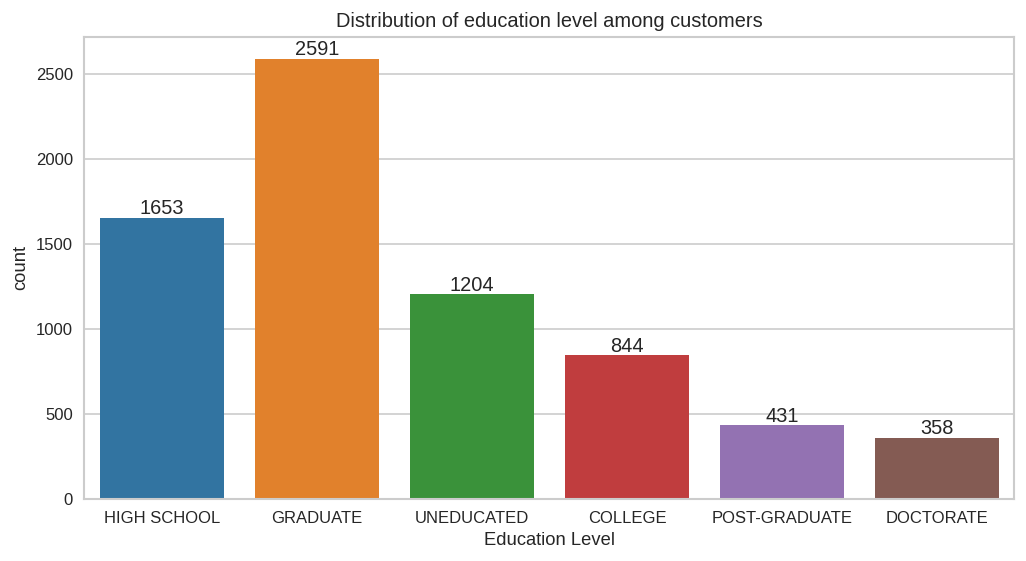

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of education level among customers')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Education_Level',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Education Level');

<ipython-input-14-7991fdc402a6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Marital_Status',palette='tab10')


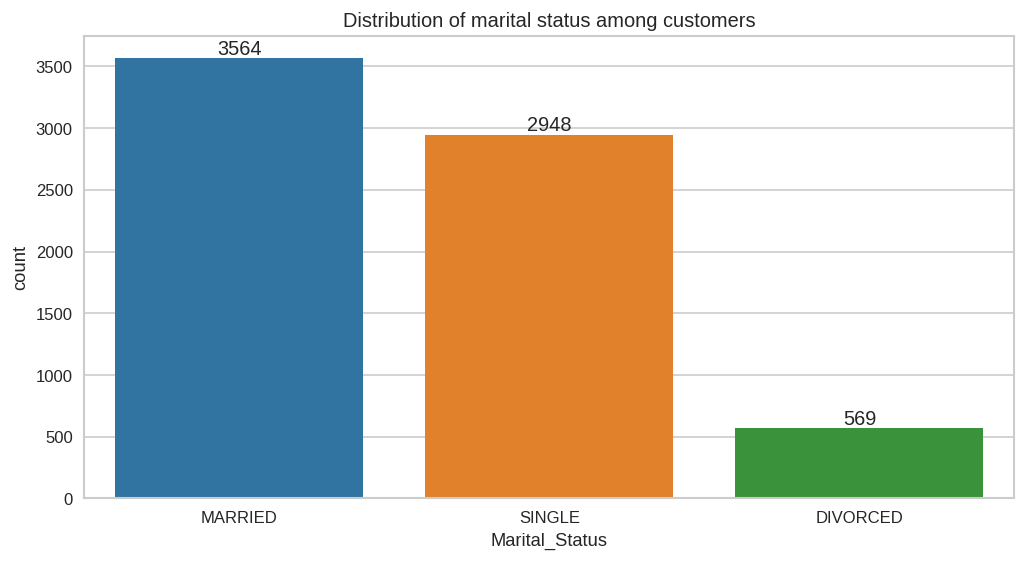

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of marital status among customers')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Marital_Status',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Marital_Status');

<ipython-input-15-81c28ee9a8f1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Income_Category',palette='tab10')


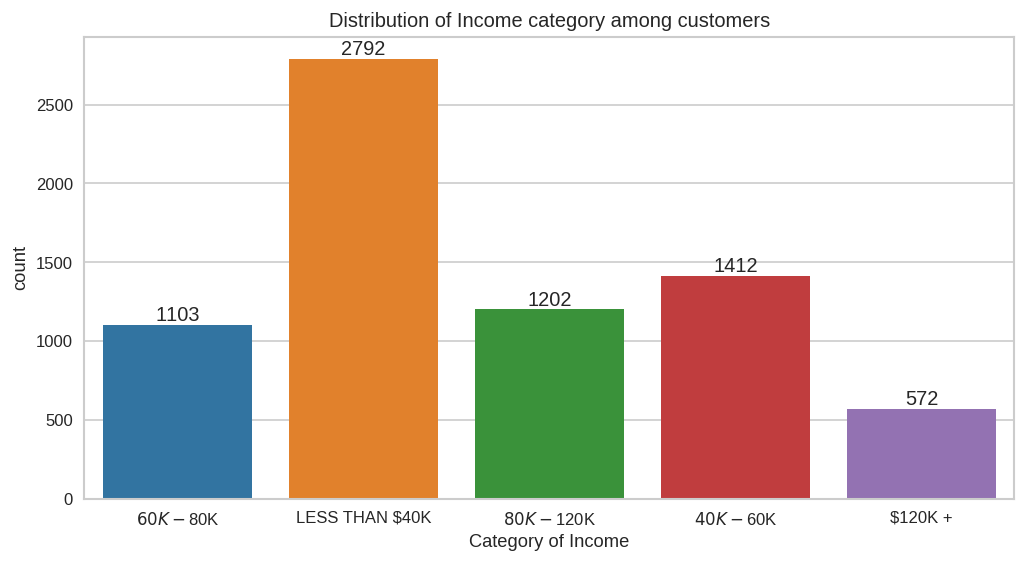

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of Income category among customers')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Income_Category',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Category of Income');

<ipython-input-16-26cda5bc846e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Card_Category',palette='tab10')


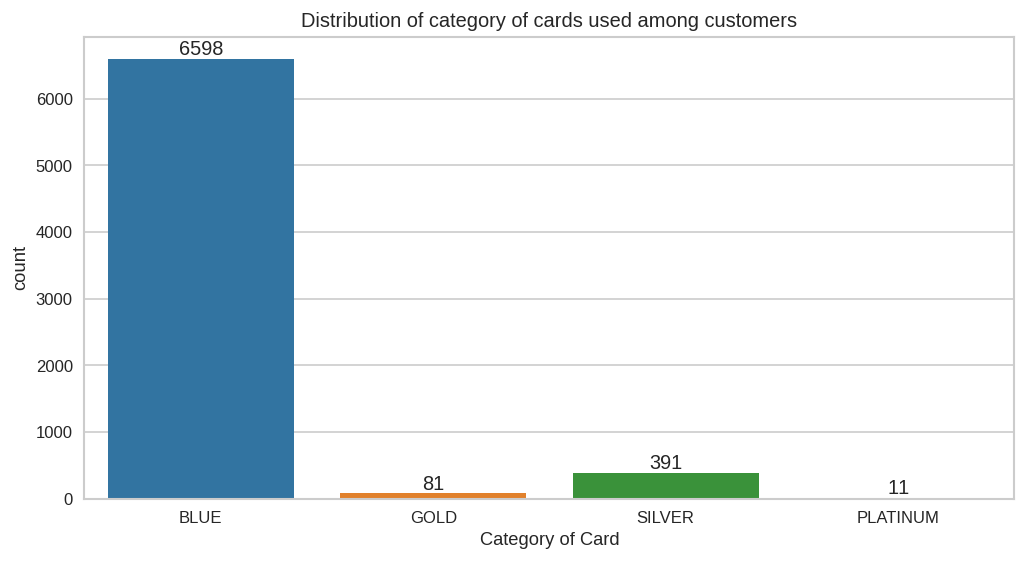

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of category of cards used among customers')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Card_Category',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Category of Card');

<ipython-input-17-7618329d333c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Dependent_count',palette='tab10')


Text(0.5, 0, 'Count of dependent')

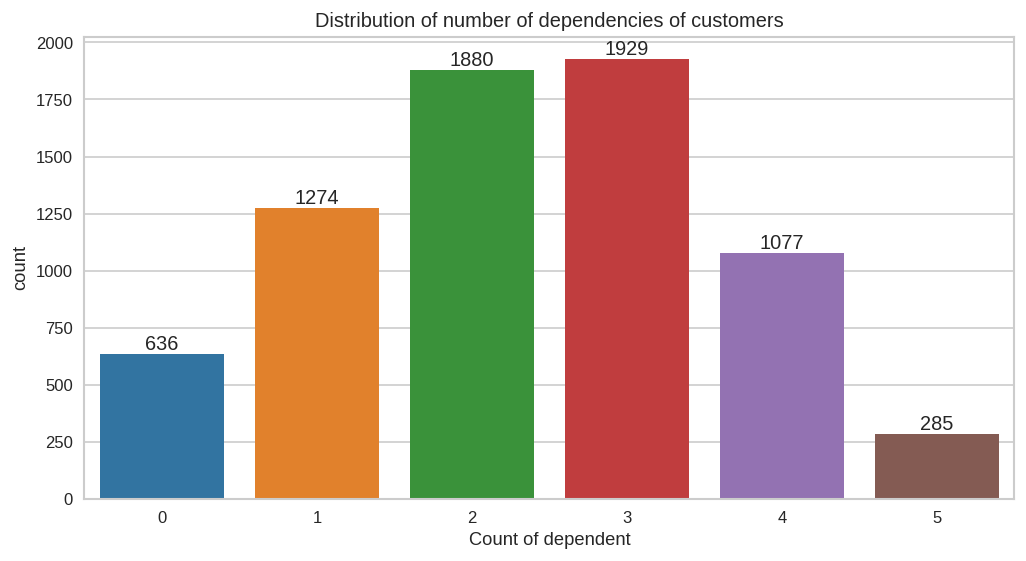

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of number of dependencies of customers')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Dependent_count',palette='tab10')
for i in a.containers: a.bar_label(i,);
plt.xlabel('Count of dependent')

<ipython-input-18-b5e16eab29ca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Months_Inactive_12_mon',palette='tab10')


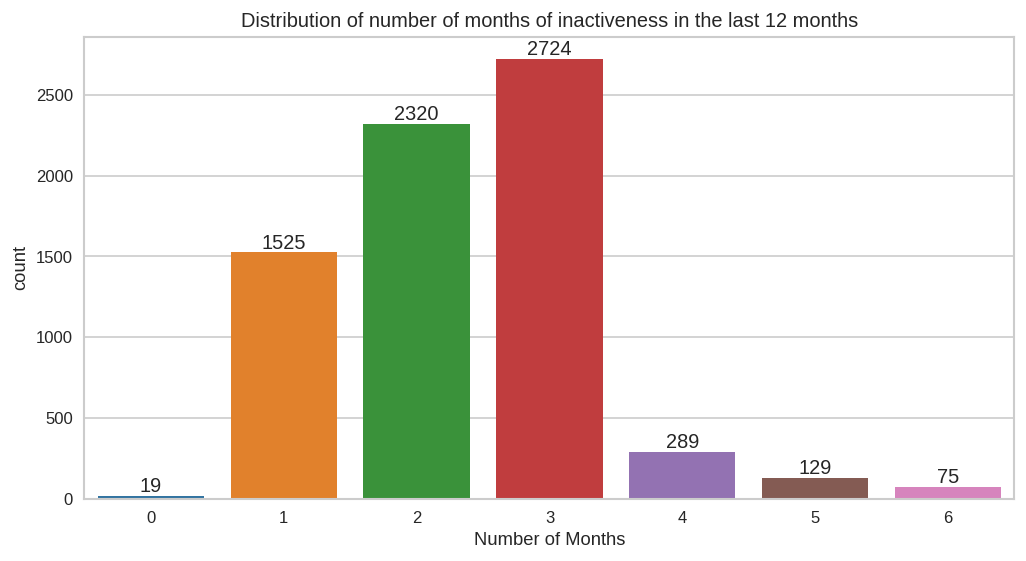

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of number of months of inactiveness in the last 12 months')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Months_Inactive_12_mon',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Number of Months');

<ipython-input-19-8ef8267f0e64>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(data=data_pandas,x='Contacts_Count_12_mon',palette='tab10')


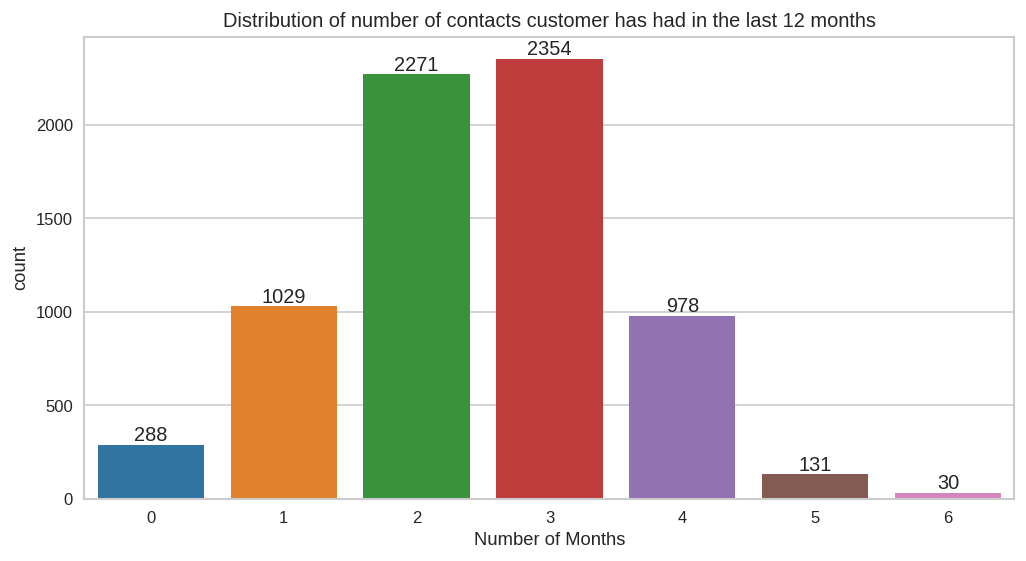

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(10,5),dpi=120)
plt.title('Distribution of number of contacts customer has had in the last 12 months')

# Biểu đồ cột
a = sns.countplot(data=data_pandas,x='Contacts_Count_12_mon',palette='tab10')
for i in a.containers: a.bar_label(i,)
plt.xlabel('Number of Months');

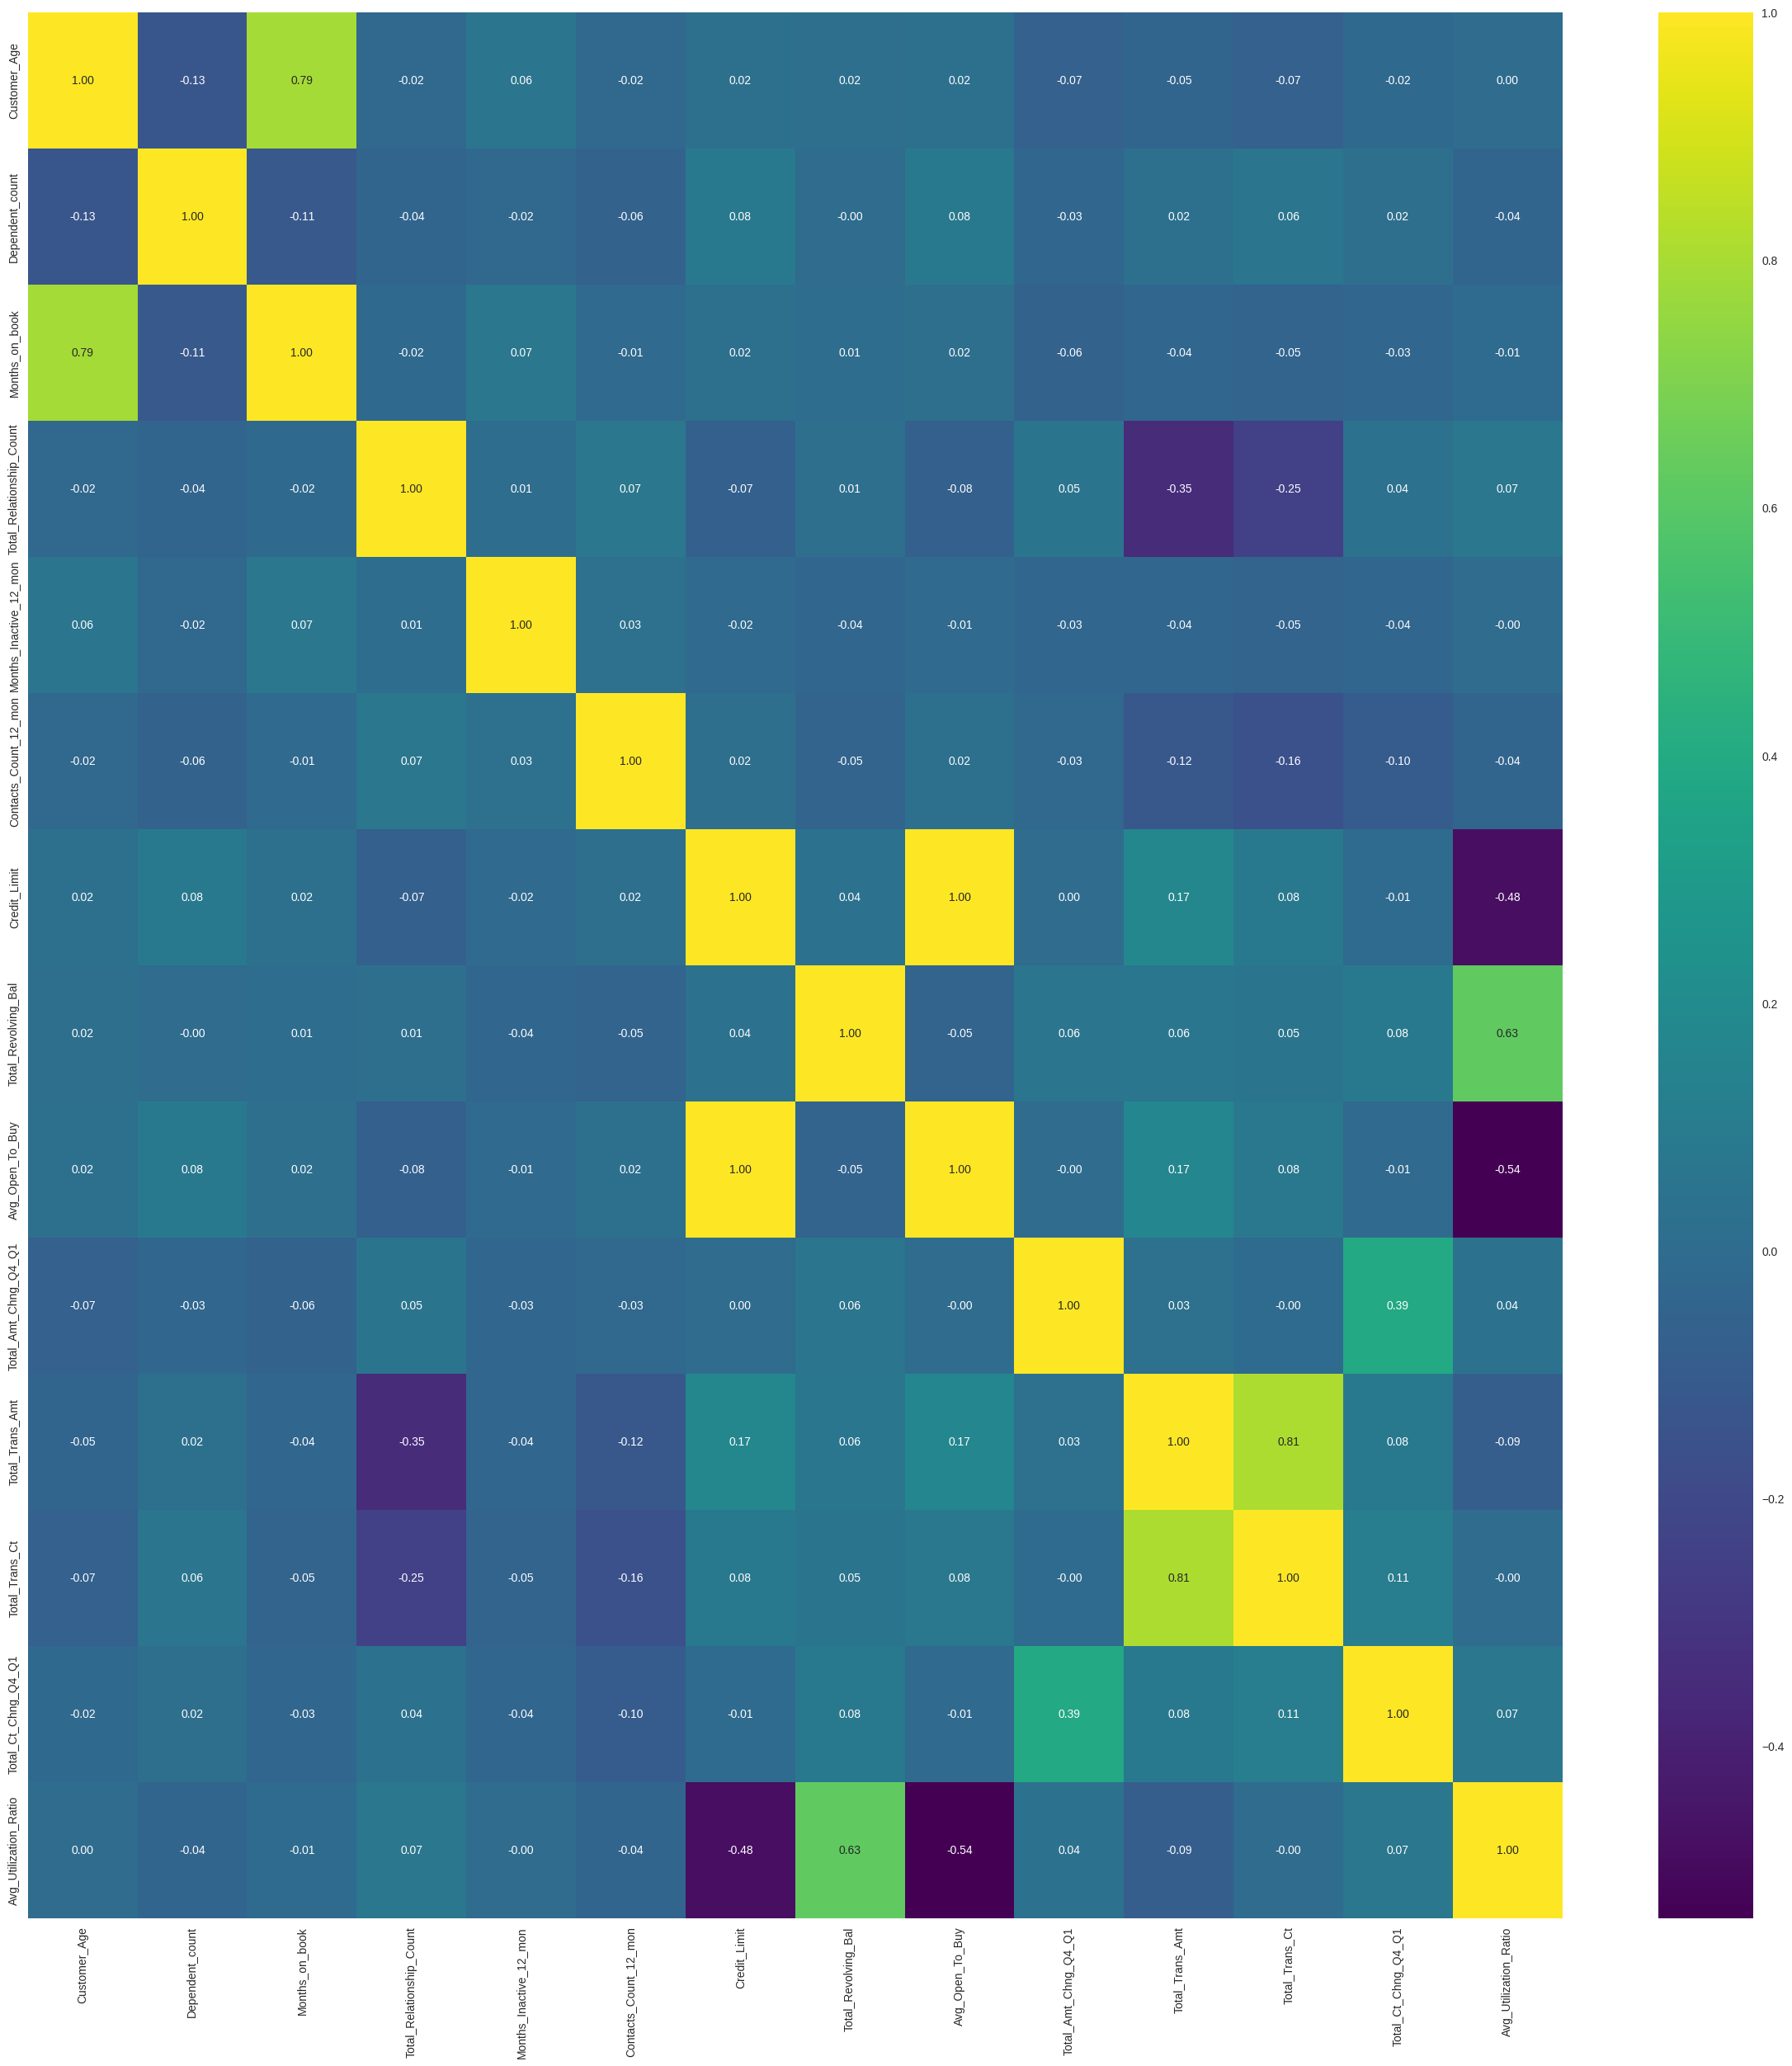

In [ ]:
data_numeric = data_pandas.select_dtypes(include=['int', 'double'])
corrmat = data_numeric.corr()
# Plot the heatmap
plt.figure(figsize=(30, 30))
#sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)
sns.heatmap(corrmat, annot=True, annot_kws={'size':10}, fmt='.2f', cmap='viridis')
plt.show()

 **Nhận xét**:
- **Tuổi của khách hàng (Customer Age)** có mối quan hệ tương quan dương cao (**0.79**) với **số tháng hoạt động (Months on Book)**. Điều này là do khi khách hàng lớn tuổi hơn, họ thường duy trì tài khoản trong thời gian dài hơn so với khách hàng trẻ tuổi.
- **Tổng số tiền giao dịch (Total Transaction Amount)** có mối tương quan dương mạnh (**0.81**) với **tổng số lượng giao dịch (Total Transaction Count)**. Điều này hợp lý vì khi một khách hàng thực hiện nhiều giao dịch, số lượng giao dịch sẽ tăng theo.
- **Tỷ lệ sử dụng tín dụng (Utilization Ratio)** là số tiền tín dụng quay vòng mà khách hàng sử dụng chia cho tổng số tín dụng sẵn có. Do đó, **Tỷ lệ sử dụng trung bình (Average Utilization Ratio)** có mối tương quan dương cao (**0.63**) với **tổng hóa đơn quay vòng (Total Revolving Bill)**. Đây cũng là lý do tại sao **Giới hạn tín dụng (Credit Limit)** lại có mối tương quan âm đáng kể (**-0.48**) với **tỷ lệ sử dụng trung bình**, vì khi giới hạn tín dụng cao hơn, tỷ lệ sử dụng tín dụng thường giảm.
- **"Open to Buy"** là sự chênh lệch giữa giới hạn tín dụng được cấp cho tài khoản của chủ thẻ và số dư hiện tại trên tài khoản đó. Vì tỷ lệ sử dụng tín dụng (Utilization Ratio) gián tiếp phụ thuộc vào giới hạn tín dụng, nên "Open to Buy" cũng gián tiếp phụ thuộc vào tỷ lệ sử dụng tín dụng. Đây là lý do tại sao chúng có mối tương quan âm.

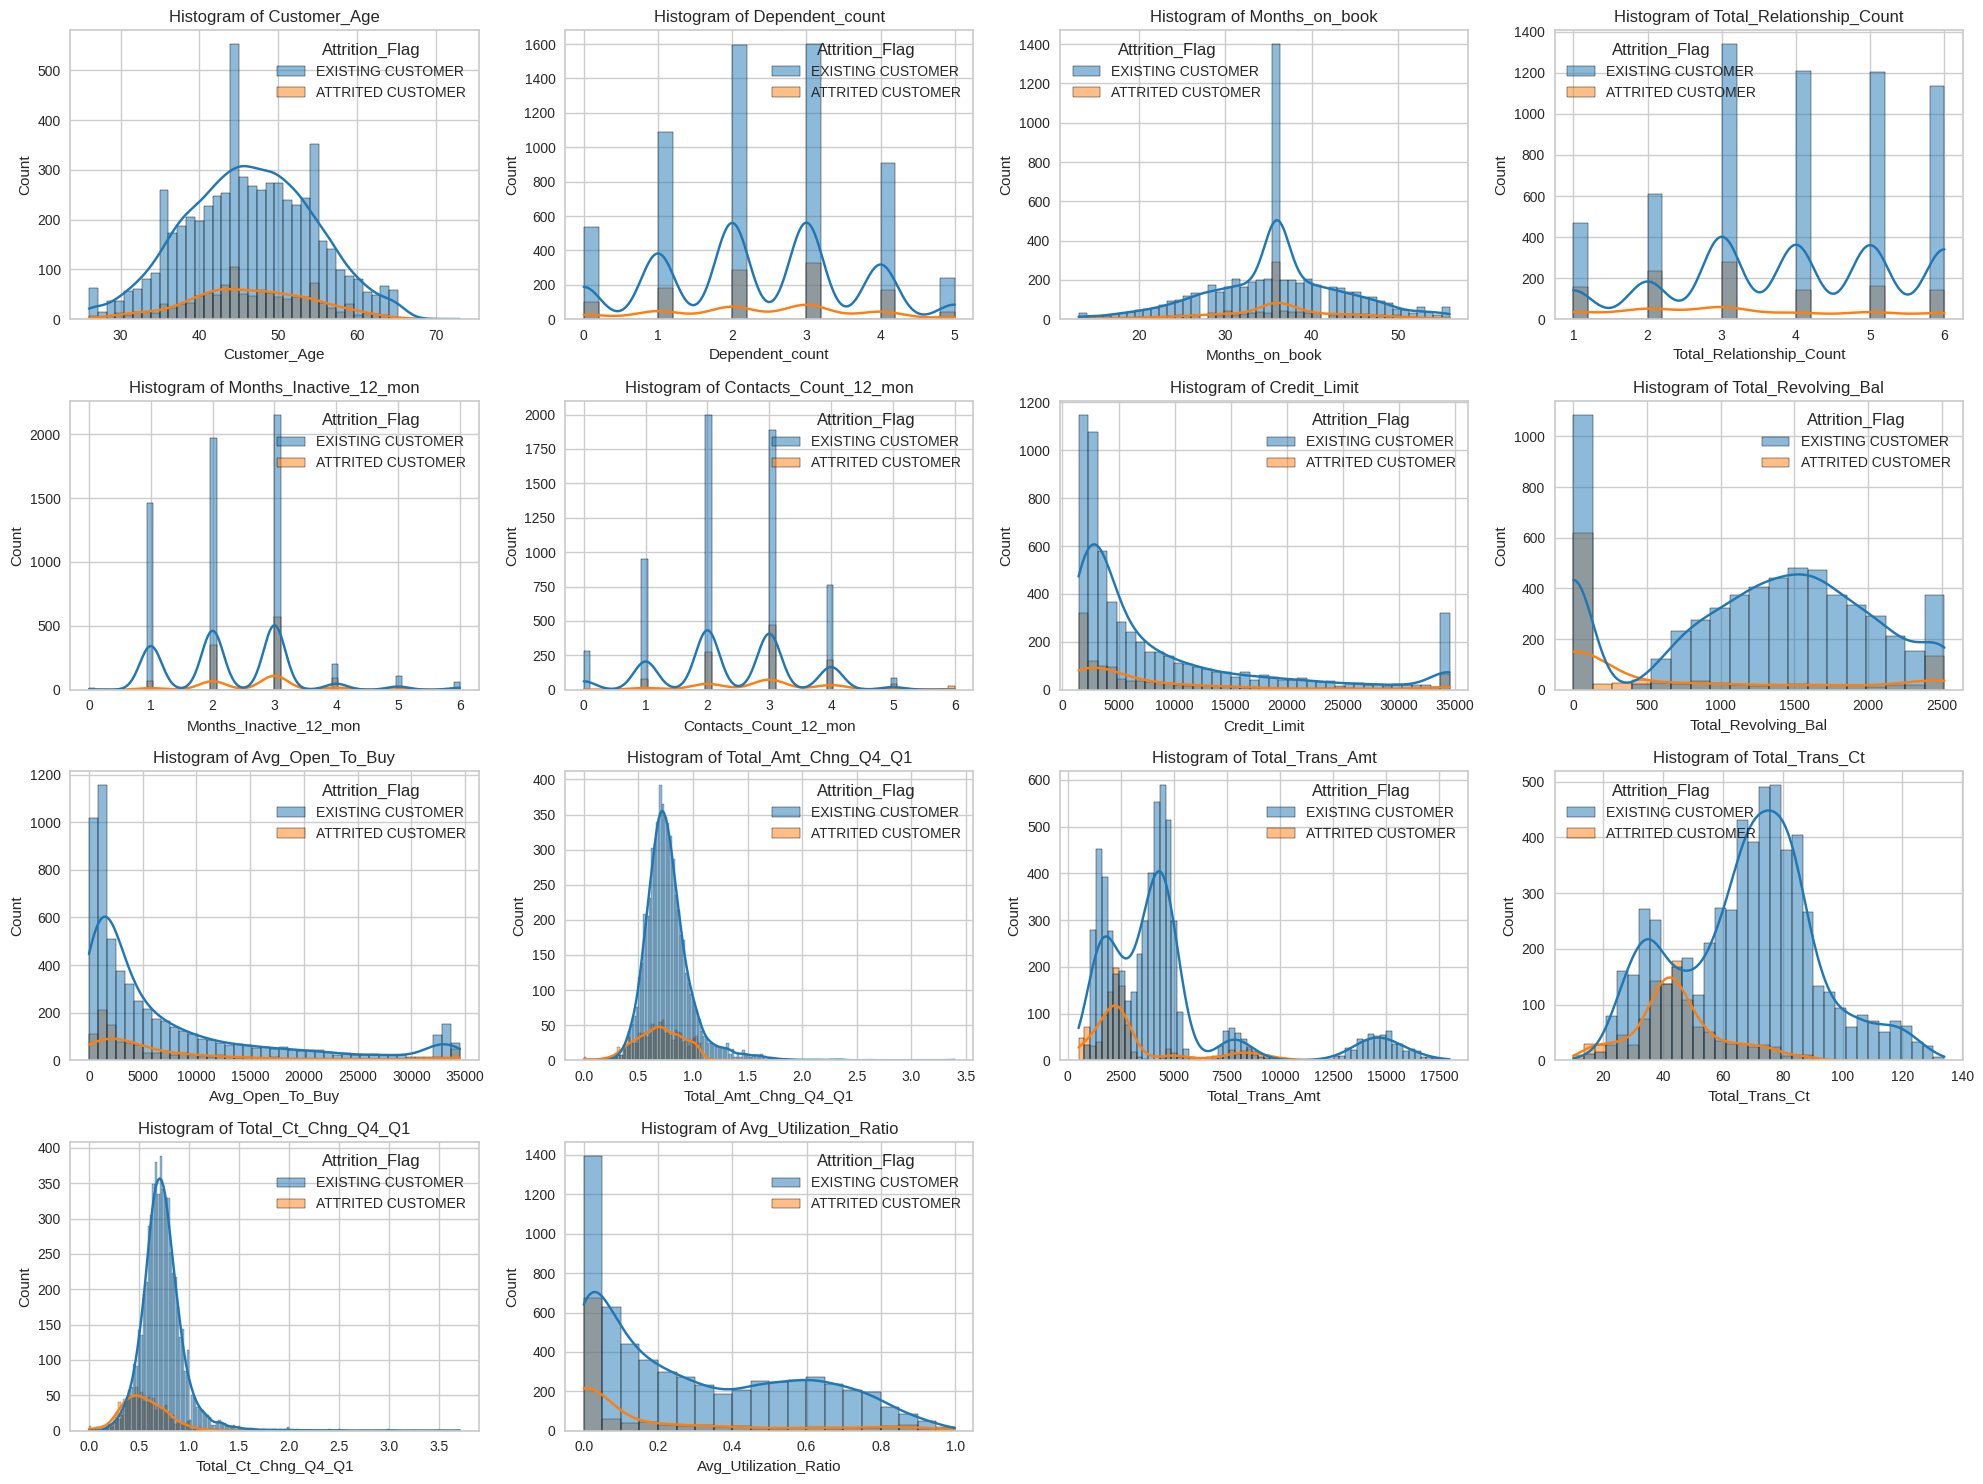

In [ ]:
columns_list = list(data_numeric.columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # Tạo lưới biểu đồ 4x4
k = 0  # Biến đếm để duyệt qua danh sách cột

for i in range(4):  # Duyệt qua các hàng
    for j in range(4):  # Duyệt qua các cột
        if k < len(columns_list):  # Nếu còn cột cần vẽ
            sns.histplot(
                data=data_pandas,
                x=columns_list[k],
                ax=axes[i, j],
                palette='tab10',
                kde=True,
                hue='Attrition_Flag'
            )
            axes[i, j].set_title(f'Histogram of {columns_list[k]}')  # Đặt tiêu đề biểu đồ
            k += 1  # Chuyển sang cột tiếp theo
        else:  # Nếu hết cột, ẩn các ô còn lại
            axes[i, j].axis('off')

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các biểu đồ


<ipython-input-22-c7c5581249a6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-22-c7c5581249a6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-22-c7c5581249a6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-22-c7c5581249a6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-22-c7c5581249a6>:7: FutureWarning: 

Passing `palette

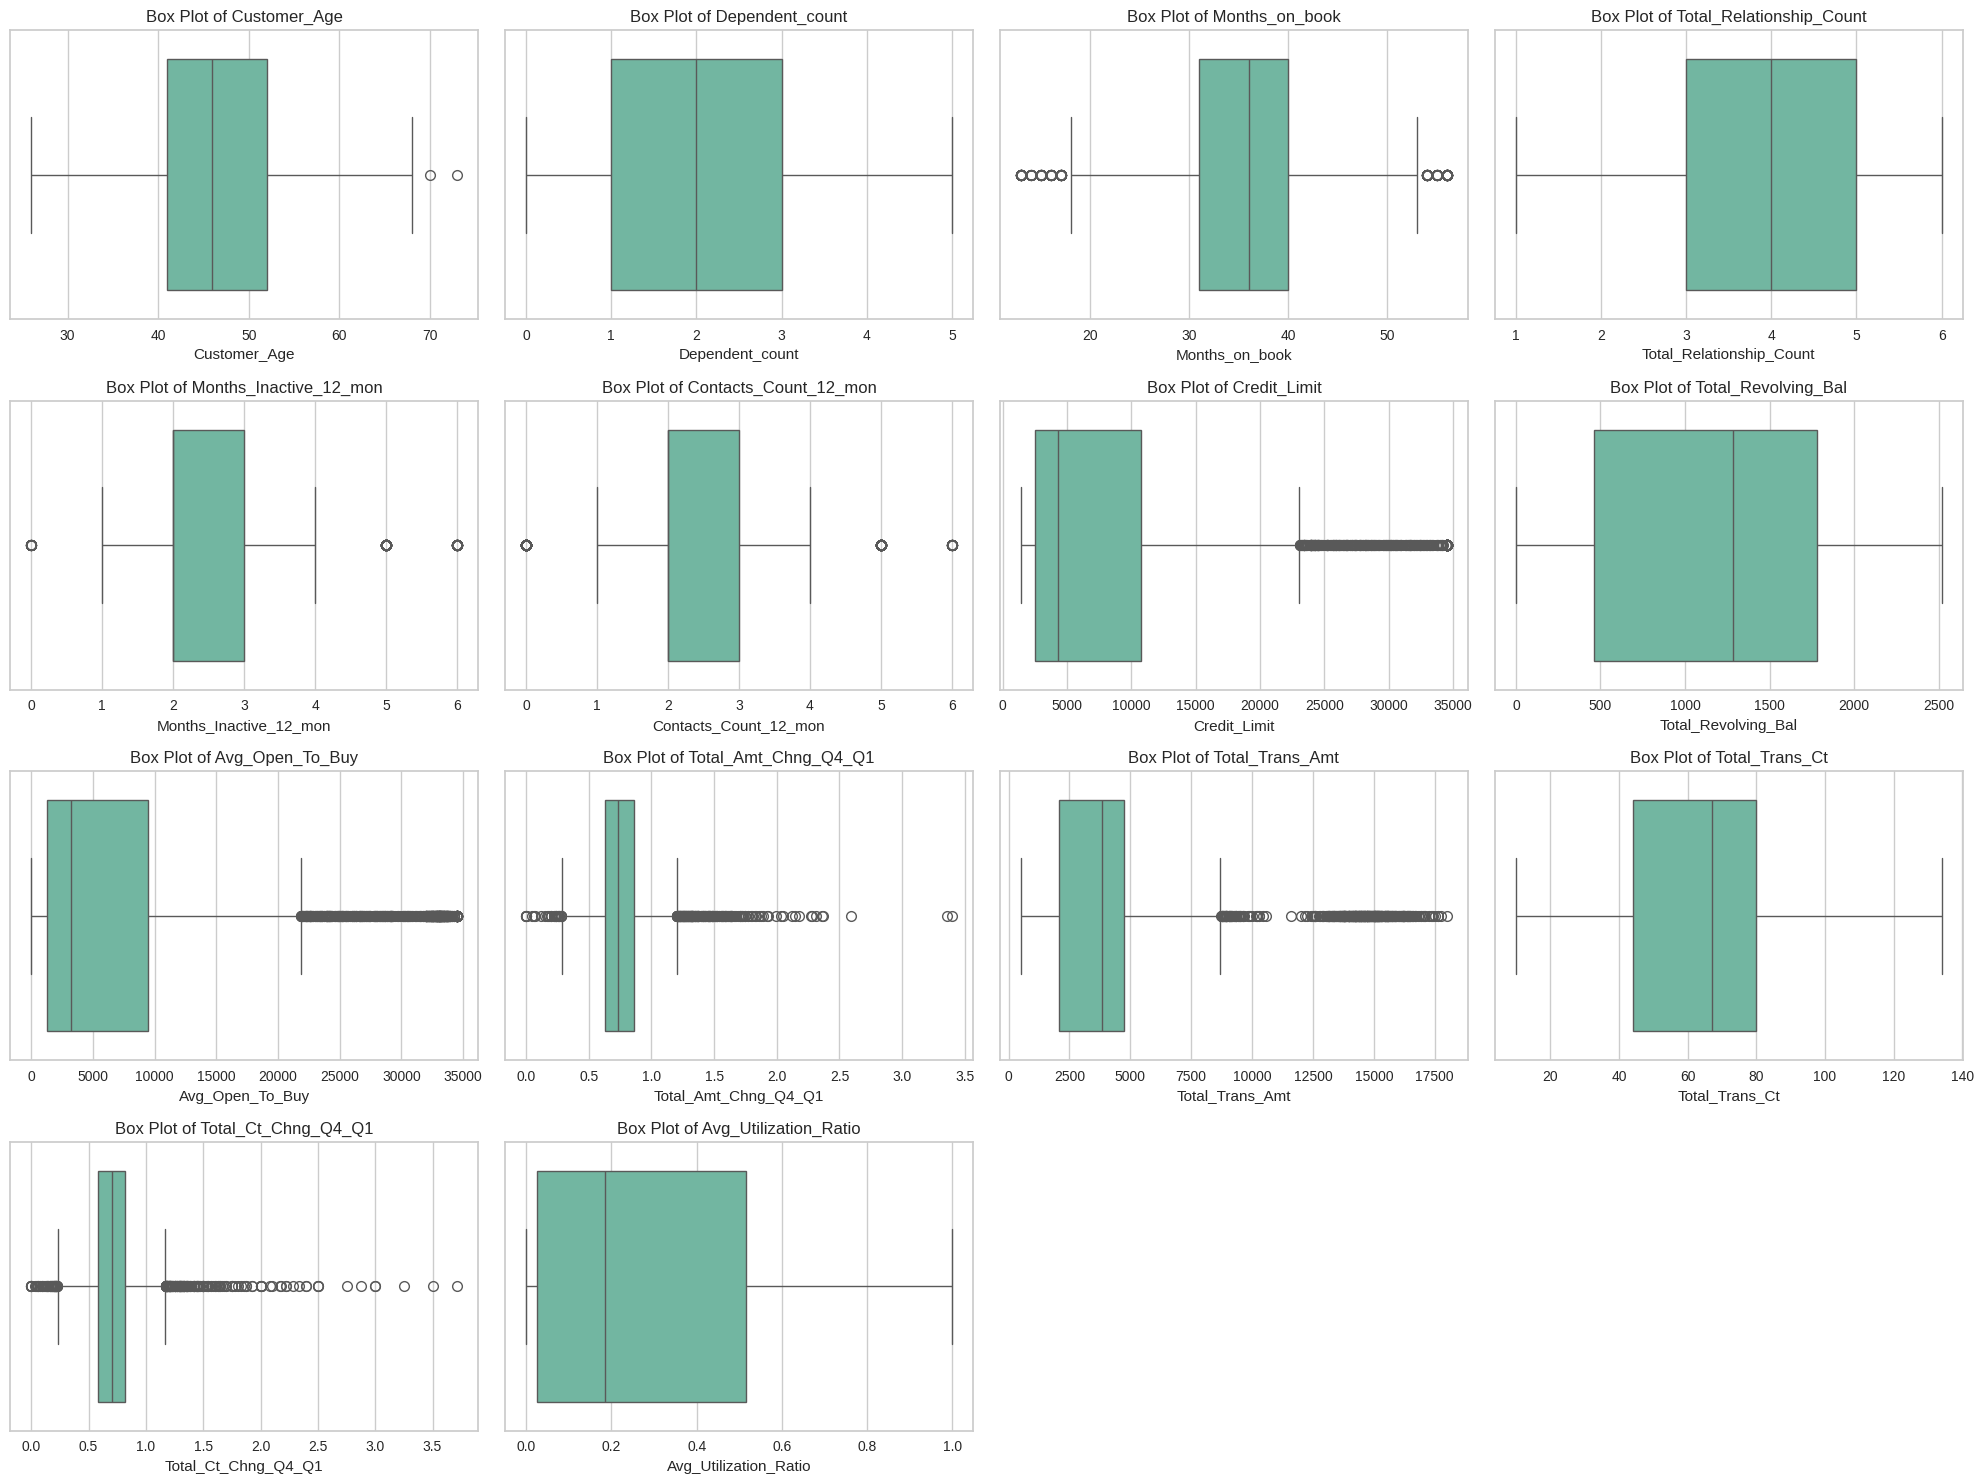

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # Tạo lưới biểu đồ 4x4
k = 0  # Biến đếm để duyệt qua danh sách cột

for i in range(4):  # Duyệt qua các hàng
    for j in range(4):  # Duyệt qua các cột
        if k < len(columns_list):  # Nếu còn cột cần vẽ
            sns.boxplot(
                data=data_pandas,
                x=columns_list[k],
                ax=axes[i, j],
                palette='Set2'
            )
            axes[i, j].set_title(f'Box Plot of {columns_list[k]}')  # Đặt tiêu đề biểu đồ
            k += 1  # Chuyển sang cột tiếp theo
        else:  # Nếu hết cột, ẩn các ô còn lại
            axes[i, j].axis('off')

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các biểu đồ

**Nhận xét**:
Những thuộc tính có nhiều outlier rõ rệt và cần xử lý:
- **Credit_Limit**: Có rất nhiều outlier ở phần giá trị cao. Việc này có thể ảnh hưởng lớn đến các mô hình phân tích.
- **Avg_Open_To_Buy**: Rất nhiều giá trị lớn vượt xa ngưỡng Q3, gây méo phân phối.
- **Total_Amt_Chng_Q4_Q1**: Xuất hiện một số outlier giá trị rất cao và thấp.
- **Total_Ct_Chng_Q4_Q1**: Có outlier ở cả hai phía dưới Q1 và trên Q3.
- **Total_Trans_Amt**: Một vài outlier rất cao nằm cách xa Q3.
- **Months_on_book**: Có outlier ở cả hai phía dưới Q1 và trên Q3.

Những thuộc tính có outlier nhưng có thể giữ lại:
- **Customer_Age**: Số lượng outlier rất ít và không gây ảnh hưởng lớn.
- **Months_Inactive_12_mon**: Các outlier khá nhỏ và không đáng kể.
- **Contacts_Count_12_mon**: Có một vài outlier nhưng vẫn nằm trong khoảng hợp lý.

In [ ]:
# Danh sách các cột cần xử lý outlier
col_To_Process_Outlier = [
    'Months_on_book',
    'Credit_Limit',
    'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Trans_Amt',
    'Total_Ct_Chng_Q4_Q1'
]

# Loại bỏ outliers cho từng cột
for column in col_To_Process_Outlier:
    # Tính toán Q1 và Q3
    bounds = data.approxQuantile(column, [0.25, 0.75], 0.001)  # approxQuantile để lấy Q1 và Q3
    Q1, Q3 = bounds[0], bounds[1]
    IQR = Q3 - Q1

    # Tính ngưỡng Lower và Upper
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc dữ liệu trong khoảng giá trị hợp lệ
    data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# In số lượng dòng sau khi xử lý outliers
print("Số dòng sau khi loại bỏ outliers cho tất cả các cột:", data.count())

Số dòng sau khi loại bỏ outliers cho tất cả các cột: 4935


Dữ liệu bây giờ khá rõ ràng và mối quan hệ giữa các thuộc tính đã được trực quan hóa. Mình sẽ làm tiếp bước tiếp theo: chuẩn bị trước dữ liệu để chuẩn bị phân cụm

## 4. DATA PREPARATION
1. Mã hóa các đặc trưng (features) phân loại bằng StringIndexer.
2. Chuẩn hóa (scale) các đặc trưng bằng Z-score.
3. Thực hiện giảm chiều dữ liệu bằng PCA (Phân tích Thành phần Chính).

### 1. Mã hóa các đặc trưng (features) phân loại bằng StringIndexer

In [ ]:
col_types = data.dtypes
categorical_cols = [col_name for col_name, data_type in col_types if data_type == 'string']
print(f"Các biến phân loại trong tập dữ liệu: {categorical_cols}")

Các biến phân loại trong tập dữ liệu: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [ ]:
# Khởi tạo StringIndexer cho từng cột
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index").fit(data) for col_name in categorical_cols]

# Áp dụng StringIndexer lên DataFrame
for indexer in indexers:
    data = indexer.transform(data)

# Chuyển đổi kiểu dữ liệu từ float sang int
for col_name in categorical_cols:
    data = data.withColumn(col_name + "_index", col(col_name + "_index").cast("int"))

# Xóa các cột gốc (dạng chuỗi)
data = data.drop(*categorical_cols)

print("Tất cả thuộc tính bây giờ là kiểu số")

Tất cả thuộc tính bây giờ là kiểu số


In [ ]:
data.show()

+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------------+------------+---------------------+--------------------+---------------------+-------------------+
|Customer_Age|Dependent_count|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag_index|Gender_index|Education_Level_index|Marital_Status_index|Income_Category_index|Card_Category_index|
+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+--------

In [ ]:
# Đổi tên
data = data.withColumnRenamed("Gender_index", "Gender")
data = data.withColumnRenamed("Attrition_Flag_index", "Attrition_Flag")
data = data.withColumnRenamed("Education_Level_index", "Education_Level")
data = data.withColumnRenamed("Marital_Status_index", "Marital_Status")
data = data.withColumnRenamed("Income_Category_index", "Income_Category")
data = data.withColumnRenamed("Card_Category_index", "Card_Category")

### 2. Chuẩn hóa (scale) các đặc trưng bằng Z-score

In [ ]:
print(data.columns)

['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [ ]:
# Tính toán giá trị trung bình và độ lệch chuẩn cho mỗi đặc trưng
# Tạo một mảng chứa giá trị trung bình và độ lệch chuẩn của mỗi đặc trưng
# Tính toán giá trị trung bình và độ lệch chuẩn cho mỗi đặc trưng
newdata = data
summary = newdata.select(
    [mean(c).alias(c + '_mean') for c in newdata.columns] +
    [stddev(c).alias(c + '_stddev') for c in newdata.columns]
).collect()[0]

# Tạo dictionary để lưu trữ giá trị trung bình và độ lệch chuẩn
means = {col_name: summary[col_name + '_mean'] for col_name in newdata.columns}
stddevs = {col_name: summary[col_name + '_stddev'] for col_name in newdata.columns}
print(means)
print(stddevs)

{'Customer_Age': 46.37325227963526, 'Dependent_count': 2.3775075987841947, 'Months_on_book': 36.03262411347518, 'Total_Relationship_Count': 3.952988855116515, 'Months_Inactive_12_mon': 2.363323201621074, 'Contacts_Count_12_mon': 2.443971631205674, 'Credit_Limit': 4805.276555217873, 'Total_Revolving_Bal': 1139.2609929078014, 'Avg_Open_To_Buy': 3666.015562310068, 'Total_Amt_Chng_Q4_Q1': 0.7295290780141831, 'Total_Trans_Amt': 3526.9598784194527, 'Total_Trans_Ct': 62.06301925025329, 'Total_Ct_Chng_Q4_Q1': 0.6853167173252268, 'Avg_Utilization_Ratio': 0.3304328267477193, 'Attrition_Flag': 0.16697061803444782, 'Gender': 0.41904761904761906, 'Education_Level': 1.4228976697061804, 'Marital_Status': 0.5754812563323202, 'Income_Category': 1.0362715298885512, 'Card_Category': 0.022492401215805473}
{'Customer_Age': 7.64056851627595, 'Dependent_count': 1.2723640534248515, 'Months_on_book': 7.251151279342349, 'Total_Relationship_Count': 1.4961844062617884, 'Months_Inactive_12_mon': 0.9946718104161012

In [ ]:
# Kết quả như ý muốn nên chạy cho toàn bộ dataset
for col_name in newdata.columns:
    newdata = newdata.withColumn(col_name, (col(col_name) - means[col_name]) / stddevs[col_name])

# Hiển thị kết quả
newdata.show()

+--------------------+-------------------+--------------------+------------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+
|        Customer_Age|    Dependent_count|      Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|        Credit_Limit| Total_Revolving_Bal|     Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|    Total_Trans_Amt|     Total_Trans_Ct| Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|     Attrition_Flag|             Gender|     Education_Level|     Marital_Status|     Income_Category|       Card_Category|
+--------------------+-------------------+--------------------+------------------------+----------------------+---------------------+-------------------

### 3. Thực hiện giảm chiều dữ liệu bằng PCA

In [ ]:
# Sử dụng VectorAssembler để kết hợp các cột đặc trưng thành một cột duy nhất dạng vector
assembler = VectorAssembler(inputCols=newdata.columns, outputCol="features")
df_features = assembler.transform(newdata)

In [ ]:
df_features.show()

+--------------------+-------------------+--------------------+------------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|        Customer_Age|    Dependent_count|      Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|        Credit_Limit| Total_Revolving_Bal|     Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|    Total_Trans_Amt|     Total_Trans_Ct| Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|     Attrition_Flag|             Gender|     Education_Level|     Marital_Status|     Income_Category|       Card_Category|            features|
+--------------------+-------------------+--------------------+------------------------+----------------------

In [ ]:
# Sử dụng PCA trên cột features, kết quả trả về là một vector đã được giảm chiều
# Tạo đối tượng PCA với số chiều giảm về 3
pca = PCA(k=3, inputCol="features", outputCol="pca_features")

# Fit PCA model trên dữ liệu
pca_model = pca.fit(df_features)

# Áp dụng PCA model để chuyển đổi dữ liệu
pca_result = pca_model.transform(df_features)

In [ ]:
pca_result.show()

+--------------------+-------------------+--------------------+------------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        Customer_Age|    Dependent_count|      Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|        Credit_Limit| Total_Revolving_Bal|     Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|    Total_Trans_Amt|     Total_Trans_Ct| Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|     Attrition_Flag|             Gender|     Education_Level|     Marital_Status|     Income_Category|       Card_Category|            features|        pca_features|
+--------------------+-------------------+--------------------+-----

In [ ]:
# Tạo hàm triết xuất user-defined function để lọc ra các PCs
def locPcs(index):
  # Chỗ này lấy giá trị thứ i của vector rồi trả về kiểu float
    def locIndex(vector):
        return float(vector[index])
         # Chỗ này trả về một hàm do người dùng xác định udf
    return udf(locIndex, DoubleType())

# Sử dụng hàm locPcs để add vào dữ liệu từ trước 3 cột (tương ứng với 3 PCs)
pca_df = pca_result.withColumn("pc1", locPcs(0)(col("pca_features"))) \
                   .withColumn("pc2", locPcs(1)(col("pca_features"))) \
                   .withColumn("pc3", locPcs(2)(col("pca_features")))

In [ ]:
pca_df.show()

+--------------------+-------------------+--------------------+------------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        Customer_Age|    Dependent_count|      Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|        Credit_Limit| Total_Revolving_Bal|     Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|    Total_Trans_Amt|     Total_Trans_Ct| Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|     Attrition_Flag|             Gender|     Education_Level|     Marital_Status|     Income_Category|       Card_Category|            features|        pca_features|      

In [ ]:
# Chọn ra 3 cột PCs để giữ lại
pca_df = pca_df.select("pc1", "pc2", "pc3")

In [ ]:
# Xem xét các thống kê mô tả
pca_df.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                 pc1|                 pc2|                 pc3|
+-------+--------------------+--------------------+--------------------+
|  count|                4935|                4935|                4935|
|   mean|1.370187313828950...|-2.05153917044817...|-2.61729172613760...|
| stddev|   1.785394463866138|  1.5431979244829277|  1.3572633629729625|
|    min|  -5.590916407716703|  -4.430795786126833| -4.2589865772506155|
|    max|   3.318780951606316|   6.098094519386263|   4.226177503920432|
+-------+--------------------+--------------------+--------------------+



In [ ]:
ds_download = pca_df.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
ds_download.to_csv('pca_data.csv', index=False)

In [ ]:
# Chuyển dữ liệu về dạng pandas dataframe để có thể trực quan hóa
plot_pca_df = pca_df.toPandas()

# Xác định cột x, y, z tương ứng với các PCs
x = plot_pca_df["pc1"]
y = plot_pca_df["pc2"]
z = plot_pca_df["pc3"]

# Tạo biểu đồ 3D
import plotly.express as px
px.defaults.template = "plotly_white"
fig = px.scatter_3d(plot_pca_df, x, y, z, color_discrete_sequence=['maroon'])
fig.update_traces(marker=dict(size=2))
fig.update_layout(title="3D Projection Of Data In The Reduced Dimension", height=600, width=800)

# Hiển thị đồ thị
fig.show()

In [ ]:
#Dừng session
spark.stop()